<a href="https://colab.research.google.com/github/lorenz0leoncin1/ROS-Autonomous-Navavigation-BehaviorTrees/blob/main/Collaborative_Filtering_Project_VErsione_finale_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Step 1: Import Libraries

In [ ]:
# Import necessary libraries for data manipulation, visualization, and similarity calculations
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
import zipfile
from sklearn.preprocessing import MinMaxScaler
import random
import time


# Step 2: Environment Setup and Data Download

In [ ]:
# Set environment variables for Kaggle API (remove before submitting)
os.environ['KAGGLE_USERNAME'] = "lorenzoleoncini"
os.environ['KAGGLE_KEY'] = "ba465f032d52fccdc84a5416c30a9071"

# Download the dataset using Kaggle API
!kaggle datasets download -d gsimonx37/letterboxd

Dataset URL: https://www.kaggle.com/datasets/gsimonx37/letterboxd
License(s): GPL-3.0
100% 22.5G/22.5G [12:39<00:00, 36.0MB/s]
100% 22.5G/22.5G [12:39<00:00, 31.8MB/s]


# Step 3: Extract Dataset


In [ ]:
# Paths and specific files
zip_file_path = 'letterboxd.zip'
extract_path = 'data/'
files_to_extract = ['actors.csv', 'genres.csv', 'movies.csv']

def extract_specific_files(zip_path, extract_dir, files_list):
    # Ensure the extraction directory exists
    os.makedirs(extract_dir, exist_ok=True)

    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        # Get the list of all files in the ZIP archive
        all_files = zip_ref.namelist()

        # Filter the files you want to extract
        files_to_extract = [file for file in all_files if file in files_list]

        # Extract only the specified files
        for file in files_to_extract:
            zip_ref.extract(file, extract_dir)
            print(f"Extracted: {file}")

# Call the function to extract specific files
extract_specific_files(zip_file_path, extract_path, files_to_extract)

Extracted: actors.csv
Extracted: genres.csv
Extracted: movies.csv


# Step 4: Load the datasets into the Dataframes

In [ ]:
RANDOM_SUBSAMPLING = True
SUBSAMPLING_SIZE = 0.04

def load_and_process_csv(file_path, chunk_size=40000, subsampling_enabled=False):
    chunks = []

    # Read and process the file in chunks
    for chunk in pd.read_csv(file_path, chunksize=chunk_size):
        chunks.append(chunk)

    # Combine chunks into a single DataFrame if necessary, check and drop duplicates
    combined_df = pd.concat(chunks, ignore_index=True)
    combined_df = combined_df.drop_duplicates()
    print(f"Shape of the DataFrame before subsampling for {file_path}: {combined_df.shape}")

    # Apply subsampling if enabled
    if subsampling_enabled:
        combined_df = combined_df.sample(frac=SUBSAMPLING_SIZE, random_state=42)
        print(f"Shape of the DataFrame after subsampling for {file_path}: {combined_df.shape}")

    return combined_df

df_actors = load_and_process_csv('data/actors.csv', subsampling_enabled=RANDOM_SUBSAMPLING)
df_genres = load_and_process_csv('data/genres.csv', subsampling_enabled=RANDOM_SUBSAMPLING)
df_movies = load_and_process_csv('data/movies.csv', subsampling_enabled=RANDOM_SUBSAMPLING)


Shape of the DataFrame before subsampling for data/actors.csv: (5797504, 3)
Shape of the DataFrame after subsampling for data/actors.csv: (231900, 3)
Shape of the DataFrame before subsampling for data/genres.csv: (1046849, 2)
Shape of the DataFrame after subsampling for data/genres.csv: (41874, 2)
Shape of the DataFrame before subsampling for data/movies.csv: (941597, 7)
Shape of the DataFrame after subsampling for data/movies.csv: (37664, 7)


In [ ]:
print(df_actors.info())
print(df_actors.head())

print(df_genres.info())
print(df_genres.head())

print(df_movies.info())
print(df_movies.head())


<class 'pandas.core.frame.DataFrame'>
Index: 231900 entries, 524783 to 1030539
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   id      231900 non-null  int64 
 1   name    231900 non-null  object
 2   role    177197 non-null  object
dtypes: int64(1), object(2)
memory usage: 7.1+ MB
None
              id                 name               role
524783   1017751         Robert Morse  J. Pierpont Finch
4631798  1545017      Daniel Bermudez     Johnny Thunder
890051   1038132  Shinnosuke Kasahara              Yoshi
270922   1007073         Gregg Daniel  English Professor
2424699  1176293      Kanako Miyamoto        Kō Sawatari
<class 'pandas.core.frame.DataFrame'>
Index: 41874 entries, 201116 to 577676
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      41874 non-null  int64 
 1   genre   41874 non-null  object
dtypes: int64(1), object(1)
memory usage: 981.4+ KB
No

In [ ]:
print(df_actors.dtypes)
print(df_genres.dtypes)
print(df_movies.dtypes)


id       int64
name    object
role    object
dtype: object
id        int64
genre    object
dtype: object
id               int64
name            object
date           float64
tagline         object
description     object
minute         float64
rating         float64
dtype: object


In [ ]:
print(df_actors.duplicated().sum())
print(df_actors.isnull().sum())

print(df_genres.duplicated().sum())
print(df_genres.isnull().sum())

print(df_movies.duplicated().sum())
print(df_movies.isnull().sum())


0
id          0
name        0
role    54703
dtype: int64
0
id       0
genre    0
dtype: int64
0
id                 0
name               3
date            3610
tagline        32033
description     6517
minute          7181
rating         33982
dtype: int64


#Step 5: Pre-Processing of 'movies' dataset

In [ ]:
df_movies.head()

,id,name,date,tagline,description,minute,rating
920492,1920493,Nesalauztie,2001.0,NaN,NaN,25.0,NaN
861368,1861369,U2 Live at Los Angeles 2018,2018.0,NaN,NaN,NaN,NaN
847808,1847809,ONDAR Florent Peyre,NaN,NaN,NaN,NaN,NaN
521859,1521860,Seed Corn Should Not Be Ground – A Portrait of...,1967.0,NaN,Tetzlaff's documentary combines historic film ...,20.0,NaN
204483,1204484,Computer Movie No.2,1969.0,NaN,Computer Movie No. 2 is a CGI animation create...,8.0,NaN


In [ ]:
df_movies.info()

<class 'pandas.core.frame.DataFrame'>
Index: 37664 entries, 920492 to 486392
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           37664 non-null  int64  
 1   name         37661 non-null  object 
 2   date         34054 non-null  float64
 3   tagline      5631 non-null   object 
 4   description  31147 non-null  object 
 5   minute       30483 non-null  float64
 6   rating       3682 non-null   float64
dtypes: float64(3), int64(1), object(3)
memory usage: 2.3+ MB


In [ ]:
# Convert 'date' column to datetime format
df_movies['date'] = pd.to_datetime(df_movies['date'], errors='coerce', format='%Y')

# Extract the year and ensure it is in integer format
df_movies['date'] = df_movies['date'].dt.year.astype('Int64')  # or 'int64' if you don't expect NaN values


In [ ]:
from sklearn.preprocessing import MinMaxScaler

# Creation of scaler
scaler = MinMaxScaler()

# Adapt and transform only 'minute' column
df_movies[['minute']] = scaler.fit_transform(df_movies[['minute']])


In [ ]:
df_movies.info()

<class 'pandas.core.frame.DataFrame'>
Index: 37664 entries, 920492 to 486392
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           37664 non-null  int64  
 1   name         37661 non-null  object 
 2   date         34054 non-null  Int64  
 3   tagline      5631 non-null   object 
 4   description  31147 non-null  object 
 5   minute       30483 non-null  float64
 6   rating       3682 non-null   float64
dtypes: Int64(1), float64(2), int64(1), object(3)
memory usage: 2.3+ MB


### Missing Data Analysis

After examining the `movies` dataset, we observed the following percentages of missing values in key columns:

- **`date`:** 9.76% missing
- **`tagline`:** 85.20% missing
- **`description`:** 17.08% missing
- **`minute`:** 19.28% missing
- **`rating`:** 90.34% missing

#### Analysis of Missing Data

1. **High Percentage of Missing Values:**
   - **`tagline` (85.20%)** and **`rating` (90.34%)** have extremely high percentages of missing data. This indicates that these fields are not reliably available or were inconsistently recorded in the dataset. Retaining these columns could introduce significant bias or reduce the robustness of any analysis that includes them.

2. **Moderate Percentage of Missing Values:**
   - **`date` (9.76%)**, **`description` (17.08%)**, and **`minute` (19.28%)** have moderate levels of missing data. While these columns have more complete data than `tagline` and `rating`, the missing values still need to be handled appropriately to ensure accurate analysis results.

#### Decision on Handling Missing Data

Given the high percentages of missing values in the `tagline` and `rating` columns, we have decided to **drop these columns** from the dataset. The rationale behind this decision is as follows:

- **`tagline`:** With over 85% of the values missing, the tagline column lacks sufficient data to contribute meaningfully to any analysis. Including this column could potentially skew results and reduce analytical clarity.

- **`rating`:** With more than 90% of the values missing, the rating column does not provide a reliable measure for movie ratings. Given the lack of data, retaining this column would not be useful for our analysis.

We are also going to drop the column `description` just because we are not gonna use it.

By dropping these columns, we aim to streamline our dataset and focus on more complete data, ensuring a more robust and reliable analysis. For the remaining columns (`date` and `minute`), we will consider appropriate imputation or data cleaning strategies to handle the missing values effectively.


In [ ]:
# Let's find the missing values of the columns: date, tagline,description,minute, rating

# Calculate the percentage of missing values for each specified column
missing_values = df_movies[['date', 'tagline', 'description', 'minute', 'rating']].isnull().sum()
missing_percentage = (missing_values / len(df_movies)) * 100

# Display the results
print("Missing Values Percentage:")
print(missing_percentage)


Missing Values Percentage:
date            9.584749
tagline        85.049384
description    17.302995
minute         19.065952
rating         90.224087
dtype: float64


In [ ]:
# Drop 'tagline' and 'rating' columns due to high percentage of missing values
df_movies.drop(columns=['tagline', 'rating','description'], inplace=True)

# Display the updated DataFrame
print(df_movies.info())


<class 'pandas.core.frame.DataFrame'>
Index: 37664 entries, 920492 to 486392
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   id      37664 non-null  int64  
 1   name    37661 non-null  object 
 2   date    34054 non-null  Int64  
 3   minute  30483 non-null  float64
dtypes: Int64(1), float64(1), int64(1), object(1)
memory usage: 1.5+ MB
None


### Analysis of remaining columns

In [ ]:
# Drop rows where 'name' is missing
df_movies = df_movies.dropna(subset=['name'])


In [ ]:
# Drop rows where 'date' is missing
df_movies = df_movies.dropna(subset=['date'])

In [ ]:
# Drop rows where 'minute' is missing
df_movies = df_movies.dropna(subset=['minute'])

In [ ]:
# Display updated DataFrame information
print(df_movies.info())

<class 'pandas.core.frame.DataFrame'>
Index: 28533 entries, 920492 to 486392
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   id      28533 non-null  int64  
 1   name    28533 non-null  object 
 2   date    28533 non-null  Int64  
 3   minute  28533 non-null  float64
dtypes: Int64(1), float64(1), int64(1), object(1)
memory usage: 1.1+ MB
None


In [ ]:
# Check for missing data in the final DataFrame
missing_values_final = df_movies.isnull().sum()
print("Missing Values Percentage After Final Processing:")
print((missing_values_final / len(df_movies)) * 100)

# Check for duplicate rows
duplicates = df_movies.duplicated().sum()
print(f"Number of duplicate rows: {duplicates}")

# Explore the dataset
print(df_movies.head())

# Save the cleaned DataFrame
df_movies.to_csv('data/cleaned_movies.csv', index=False)


Missing Values Percentage After Final Processing:
id        0.0
name      0.0
date      0.0
minute    0.0
dtype: float64
Number of duplicate rows: 0
             id                                               name  date  \
920492  1920493                                        Nesalauztie  2001   
521859  1521860  Seed Corn Should Not Be Ground – A Portrait of...  1967   
204483  1204484                                Computer Movie No.2  1969   
574741  1574742                                     Boss With Love  2023   
668553  1668554                             My Sister-in-law's Job  2017   

          minute  
920492  0.006840  
521859  0.005415  
204483  0.001995  
574741  0.023938  
668553  0.025078  


# Step 6: Pre-Processing of 'actors' dataset

In [ ]:
# Overview of the actors DataFrame
print(df_actors.info())
print(df_actors.head())

<class 'pandas.core.frame.DataFrame'>
Index: 231900 entries, 524783 to 1030539
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   id      231900 non-null  int64 
 1   name    231900 non-null  object
 2   role    177197 non-null  object
dtypes: int64(1), object(2)
memory usage: 7.1+ MB
None
              id                 name               role
524783   1017751         Robert Morse  J. Pierpont Finch
4631798  1545017      Daniel Bermudez     Johnny Thunder
890051   1038132  Shinnosuke Kasahara              Yoshi
270922   1007073         Gregg Daniel  English Professor
2424699  1176293      Kanako Miyamoto        Kō Sawatari


In [ ]:
# Check for missing values in the actors DataFrame
missing_values_actors = df_actors.isnull().sum()
missing_percentage_actors = (missing_values_actors / len(df_actors)) * 100

print("Missing Values Percentage in Actors Table:")
print(missing_percentage_actors)

Missing Values Percentage in Actors Table:
id       0.000000
name     0.000000
role    23.589047
dtype: float64


In [ ]:
# Deleting the role column
df_actors = df_actors.drop(columns=['role'])

print(df_actors.head())

              id                 name
524783   1017751         Robert Morse
4631798  1545017      Daniel Bermudez
890051   1038132  Shinnosuke Kasahara
270922   1007073         Gregg Daniel
2424699  1176293      Kanako Miyamoto


In [ ]:
# Assume df_actor_movie is already defined
# Group by 'id' and 'actor_name' and count the number of rows in each group
grouped = df_actors.groupby(['id', 'name']).size().reset_index(name='count')

# Filter to show only groups with more than one row
duplicates = grouped[grouped['count'] > 1]

# Display the duplicate associations
print("Duplicate associations between id and name:")
print(duplicates)

# Optional: Display the total number of duplicate associations
print(f"Total number of duplicate associations: {duplicates.shape[0]}")


Duplicate associations between id and name:
             id              name  count
105129  1200914  Michael Basinski      2
228033  1884712    Richard Harris      2
Total number of duplicate associations: 2


In [ ]:
# Remove duplicate rows, keeping only the first occurrence
df_actors = df_actors.drop_duplicates(subset=['id', 'name'])

# Check the updated DataFrame
print(df_actors.head())


              id                 name
524783   1017751         Robert Morse
4631798  1545017      Daniel Bermudez
890051   1038132  Shinnosuke Kasahara
270922   1007073         Gregg Daniel
2424699  1176293      Kanako Miyamoto


In [ ]:
# Remove rows where 'name' is missing
df_actors.dropna(subset=['name'], inplace=True)

In [ ]:
# Convert all names and roles to lowercase for consistency
df_actors['name'] = df_actors['name'].str.lower()

In [ ]:
# Optimize the id column if needed (convert to int32 if applicable)
df_actors['id'] = df_actors['id'].astype('int32')

In [ ]:
df_actors.head()

,id,name
524783,1017751,robert morse
4631798,1545017,daniel bermudez
890051,1038132,shinnosuke kasahara
270922,1007073,gregg daniel
2424699,1176293,kanako miyamoto


In [ ]:
# Count number of unique actors
num_unique_actors = df_actors['name'].nunique()
print(f"Number of unique actors: {num_unique_actors}")


Number of unique actors: 166284


In [ ]:
# List unique actors
unique_actors = df_actors['name'].unique()
print(f"Number of unique actors: {len(unique_actors)}")
print("First 10 unique actors:")
print(unique_actors[:10])


Number of unique actors: 166284
First 10 unique actors:
['robert morse' 'daniel bermudez' 'shinnosuke kasahara' 'gregg daniel'
 'kanako miyamoto' 'rosie alvarez' 'lettie shumate' 'samuel joslin'
 'rajaa mounssif' 'v. larin']


In [ ]:
# Check for actors with duplicate names
duplicate_actors = df_actors[df_actors.duplicated(subset=['name'], keep=False)]
print(f"Number of rows with duplicate actors: {duplicate_actors.shape[0]}")


Number of rows with duplicate actors: 99717


In [ ]:
# Count the number of participations per actor
actor_participations = df_actors['name'].value_counts()
print(actor_participations.head(10))  # Show the top 10 actors with the most participations


name
mel blanc            45
bess flowers         40
manorama             26
sukumari             21
brahmanandam         21
oskar sima           19
sankaradi            19
lee phelps           18
frank welker         18
jagathy sreekumar    18
Name: count, dtype: int64


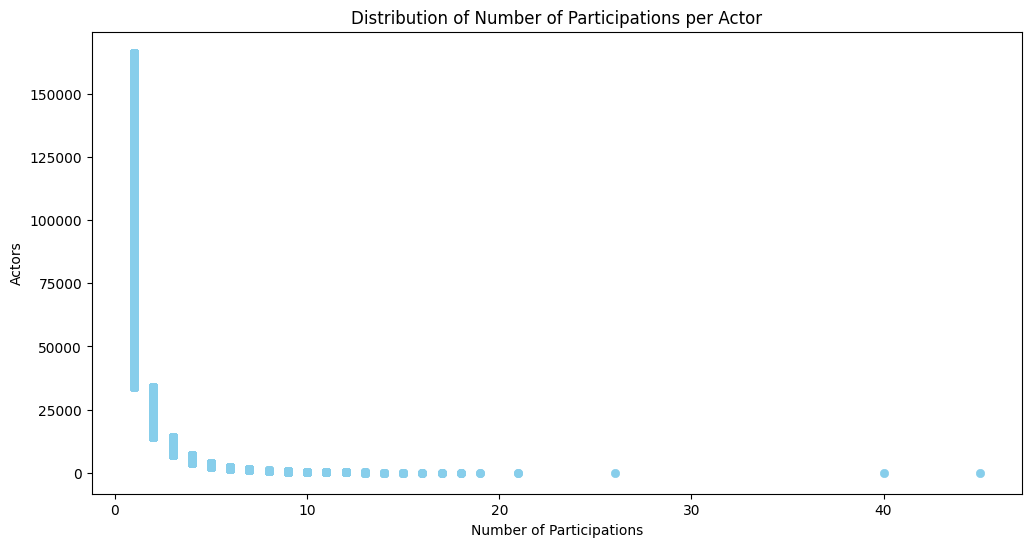

In [ ]:
# Count the number of participations for each actor
actor_participations = df_actors['name'].value_counts().reset_index()
actor_participations.columns = ['actor', 'participations']

# Configure the plot
plt.figure(figsize=(12, 6))
sns.scatterplot(x='participations', y=actor_participations.index, data=actor_participations, color='skyblue', edgecolor=None)
plt.title('Distribution of Number of Participations per Actor')
plt.xlabel('Number of Participations')
plt.ylabel('Actors')
plt.show()


In [ ]:
# Count the total number of duplicate rows in the DataFrame
duplicate_count = df_actors.duplicated().sum()

print(f"Number of duplicate rows in df_actors: {duplicate_count}")


Number of duplicate rows in df_actors: 0


In [ ]:
# Find and display duplicate rows
duplicate_rows = df_actors[df_actors.duplicated()]

print("Duplicate rows in df_actors:")
print(duplicate_rows)


Duplicate rows in df_actors:
Empty DataFrame
Columns: [id, name]
Index: []


In [ ]:
# Find and display duplicate rows along with their occurrence counts
duplicate_rows_with_count = df_actors[df_actors.duplicated(keep=False)]
duplicate_counts = duplicate_rows_with_count.groupby(list(df_actors.columns)).size().reset_index(name='count')

print("Duplicate rows and their occurrence counts:")
print(duplicate_counts)


Duplicate rows and their occurrence counts:
Empty DataFrame
Columns: [id, name, count]
Index: []


In [ ]:
# Remove duplicate rows, keeping only the first occurrence
df_actors_unique = df_actors.drop_duplicates()

print(f"Shape of the DataFrame after removing duplicates: {df_actors_unique.shape}")


Shape of the DataFrame after removing duplicates: (231898, 2)


#Step 7: Pre-Processing of 'genre' dataset

In [ ]:
print(df_genres.info())
print(df_genres.head())

<class 'pandas.core.frame.DataFrame'>
Index: 41874 entries, 201116 to 577676
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      41874 non-null  int64 
 1   genre   41874 non-null  object
dtypes: int64(1), object(1)
memory usage: 981.4+ KB
None
             id            genre
201116  1102360           Horror
700610  1499528  Science Fiction
992349  1843017            Drama
141147  1067955            Drama
862078  1676465      Documentary


In [ ]:
missing_values = df_genres.isnull().sum()
missing_percentage = (missing_values / len(df_genres)) * 100

print("Missing Values Percentage in Genres Table:")
print(missing_percentage)


Missing Values Percentage in Genres Table:
id       0.0
genre    0.0
dtype: float64


In [ ]:
duplicate_rows = df_genres[df_genres.duplicated()]
print("Duplicated Rows:")
print(duplicate_rows)

Duplicated Rows:
Empty DataFrame
Columns: [id, genre]
Index: []


In [ ]:
df_genres['genre'] = df_genres['genre'].str.lower()

In [ ]:
# Convert id to a more memory-efficient type if applicable
df_genres['id'] = df_genres['id'].astype('int32')

In [ ]:
print(df_genres.info())

<class 'pandas.core.frame.DataFrame'>
Index: 41874 entries, 201116 to 577676
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      41874 non-null  int32 
 1   genre   41874 non-null  object
dtypes: int32(1), object(1)
memory usage: 817.9+ KB
None


In [ ]:
df_genres.head()

,id,genre
201116,1102360,horror
700610,1499528,science fiction
992349,1843017,drama
141147,1067955,drama
862078,1676465,documentary


##Group by Movie ID and Aggregate Genres
   - Group the `genres` DataFrame by the `id` column (which represents the movie ID).
   - Concatenate all `genre` values for each movie into a single string, with genres separated by commas.


In [ ]:
# Group by 'id' and aggregate genres into a single string separated by commas
df_genres = df_genres.groupby('id')['genre'].apply(lambda x: ', '.join(x)).reset_index()

# Rename the aggregated genre column for clarity
df_genres.rename(columns={'genre': 'genres'}, inplace=True)
print(df_genres.head())

        id           genres
0  1000019            drama
1  1000028  science fiction
2  1000037          romance
3  1000069            drama
4  1000073            drama


In [ ]:
print(df_genres.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41035 entries, 0 to 41034
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      41035 non-null  int32 
 1   genres  41035 non-null  object
dtypes: int32(1), object(1)
memory usage: 481.0+ KB
None


# Step 8: Making considerations about dfs

In [ ]:
# Informations about the three tables, df_movies, df_actors and df_genres

# Display information about df_movies
print("df_movies Information:")
print(df_movies.info())
print(df_movies.head())
print("\n")

# Display information about df_actors
print("df_actors Information:")
print(df_actors.info())
print(df_actors.head())
print("\n")

# Display information about df_genres_aggregated (since it's the processed genres table)
print("df_genres Information:")
print(df_genres.info())
print(df_genres.head())


df_movies Information:
<class 'pandas.core.frame.DataFrame'>
Index: 28533 entries, 920492 to 486392
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   id      28533 non-null  int64  
 1   name    28533 non-null  object 
 2   date    28533 non-null  Int64  
 3   minute  28533 non-null  float64
dtypes: Int64(1), float64(1), int64(1), object(1)
memory usage: 1.1+ MB
None
             id                                               name  date  \
920492  1920493                                        Nesalauztie  2001   
521859  1521860  Seed Corn Should Not Be Ground – A Portrait of...  1967   
204483  1204484                                Computer Movie No.2  1969   
574741  1574742                                     Boss With Love  2023   
668553  1668554                             My Sister-in-law's Job  2017   

          minute  
920492  0.006840  
521859  0.005415  
204483  0.001995  
574741  0.023938  
668553  0.025078 

# Step 9: Merging movies and their genres

In [ ]:
# Merge df_movies with df_genres to include genres in the utility matrix
df_movies_with_genres = pd.merge(df_movies, df_genres, on='id', how='inner')

df_movies_with_genres.head()


,id,name,date,minute,genres
0,1037588,Love Camp 7,1969,0.027073,horror
1,1153147,Rendezvous in Chicago,2018,0.019379,romance
2,1389862,Troubled Water,2020,0.002565,animation
3,1115592,King Ordinary,2013,0.027358,tv movie
4,1173462,Jorginho Guinle - $ó Se Vive uma Vez,2019,0.025933,drama


One-Hot Encoding on genres cause is a categorical feature and then our df for moies is ready


In [ ]:
# One Hot Encoding
df_movies_with_genres = df_movies_with_genres.join(df_movies_with_genres['genres'].str.get_dummies(', '))
# Removing one-hot encoded column
df_movies_with_genres = df_movies_with_genres.drop(columns=['genres'])
df_movies_with_genres.head()

,id,name,date,minute,action,adventure,animation,comedy,crime,documentary,...,history,horror,music,mystery,romance,science fiction,thriller,tv movie,war,western
0,1037588,Love Camp 7,1969,0.027073,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
1,1153147,Rendezvous in Chicago,2018,0.019379,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
2,1389862,Troubled Water,2020,0.002565,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1115592,King Ordinary,2013,0.027358,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,1173462,Jorginho Guinle - $ó Se Vive uma Vez,2019,0.025933,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
# Merge the resulting table with df_actors to have actors, movies, and genres together
df_actor_movie_genre = pd.merge(df_actors, df_movies_with_genres, on='id', how='inner')
df_actor_movie_genre.head()

,id,name_x,name_y,date,minute,action,adventure,animation,comedy,crime,...,history,horror,music,mystery,romance,science fiction,thriller,tv movie,war,western
0,1027454,angela alvarado,I'll Do Anything,1994,0.032488,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,1027454,roz baker,I'll Do Anything,1994,0.032488,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,1018387,hatta azad khan,Hala,2019,0.026218,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1018387,taylor marie blim,Hala,2019,0.026218,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1587557,mack fluker,The Helpless Helper,1927,0.006270,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
# Print column names to check if 'name' exists
print(df_actor_movie_genre.columns)


Index(['id', 'name_x', 'name_y', 'date', 'minute', 'action', 'adventure',
       'animation', 'comedy', 'crime', 'documentary', 'drama', 'family',
       'fantasy', 'history', 'horror', 'music', 'mystery', 'romance',
       'science fiction', 'thriller', 'tv movie', 'war', 'western'],
      dtype='object')


In [ ]:
# Rename columns for clarity
df_actor_movie_genre.rename(columns={'name_x': 'actor_name', 'name_y': 'movie_name'}, inplace=True)

# Analysis of the issue in genre e movies

In [ ]:
df_actor_movie_genre.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 613 entries, 0 to 612
Data columns (total 24 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               613 non-null    int32  
 1   actor_name       613 non-null    object 
 2   movie_name       613 non-null    object 
 3   date             613 non-null    Int64  
 4   minute           613 non-null    float64
 5   action           613 non-null    int64  
 6   adventure        613 non-null    int64  
 7   animation        613 non-null    int64  
 8   comedy           613 non-null    int64  
 9   crime            613 non-null    int64  
 10  documentary      613 non-null    int64  
 11  drama            613 non-null    int64  
 12  family           613 non-null    int64  
 13  fantasy          613 non-null    int64  
 14  history          613 non-null    int64  
 15  horror           613 non-null    int64  
 16  music            613 non-null    int64  
 17  mystery         

In [ ]:
print(df_actor_movie_genre.shape)


(613, 24)


In [ ]:
print("Dimensions of df_actors before the merge:", df_actors.shape)
print("Dimensions of df_movies_with_genres before the merge:", df_movies_with_genres.shape)
print("Dimensions of df_actor_movie_genre after the merge:", df_actor_movie_genre.shape)


Dimensions of df_actors before the merge: (231898, 2)
Dimensions of df_movies_with_genres before the merge: (1403, 23)
Dimensions of df_actor_movie_genre after the merge: (613, 24)


In [ ]:
# Print the number of unique IDs in df_actors
print("Unique IDs in df_actors:", df_actors['id'].nunique())

# Print the number of unique IDs in df_movies_with_genres
print("Unique IDs in df_movies_with_genres:", df_movies_with_genres['id'].nunique())


Unique IDs in df_actors: 169905
Unique IDs in df_movies_with_genres: 1403


In [ ]:
print(df_actors['id'].isnull().sum())
print(df_movies_with_genres['id'].isnull().sum())


0
0


In [ ]:
print(df_actor_movie_genre.head())
print(df_actor_movie_genre.info())


        id         actor_name           movie_name  date    minute  action  \
0  1027454    angela alvarado     I'll Do Anything  1994  0.032488       0   
1  1027454          roz baker     I'll Do Anything  1994  0.032488       0   
2  1018387    hatta azad khan                 Hala  2019  0.026218       0   
3  1018387  taylor marie blim                 Hala  2019  0.026218       0   
4  1587557        mack fluker  The Helpless Helper  1927  0.006270       0   

   adventure  animation  comedy  crime  ...  history  horror  music  mystery  \
0          0          0       1      0  ...        0       0      0        0   
1          0          0       1      0  ...        0       0      0        0   
2          0          0       0      0  ...        0       0      0        0   
3          0          0       0      0  ...        0       0      0        0   
4          0          0       1      0  ...        0       0      0        0   

   romance  science fiction  thriller  tv movie  w

In [ ]:
# Print the number of duplicate rows in df_actors
print("Duplicates in df_actors:", df_actors.duplicated().sum())

# Print the number of duplicate rows in df_movies_with_genres
print("Duplicates in df_movies_with_genres:", df_movies_with_genres.duplicated().sum())


Duplicates in df_actors: 0
Duplicates in df_movies_with_genres: 0


In [ ]:
# Print the distribution of IDs in df_actors
print("Distribution of IDs in df_actors:")
print(df_actors['id'].value_counts().describe())

# Print the distribution of IDs in df_movies_with_genres
print("Distribution of IDs in df_movies_with_genres:")
print(df_movies_with_genres['id'].value_counts().describe())


Distribution of IDs in df_actors:
count    169905.000000
mean          1.364869
std           0.775703
min           1.000000
25%           1.000000
50%           1.000000
75%           2.000000
max          29.000000
Name: count, dtype: float64
Distribution of IDs in df_movies_with_genres:
count    1403.0
mean        1.0
std         0.0
min         1.0
25%         1.0
50%         1.0
75%         1.0
max         1.0
Name: count, dtype: float64


In [ ]:
# Find IDs in df_actors that are not present in df_movies_with_genres
missing_ids = df_actors[~df_actors['id'].isin(df_movies_with_genres['id'])]

# Print the number of IDs in df_actors that are not in df_movies_with_genres
print("Number of IDs in df_actors that are not in df_movies_with_genres:", len(missing_ids))

# Print the first few rows of missing IDs
print(missing_ids.head())


Number of IDs in df_actors that are not in df_movies_with_genres: 231285
              id                 name
524783   1017751         robert morse
4631798  1545017      daniel bermudez
890051   1038132  shinnosuke kasahara
270922   1007073         gregg daniel
2424699  1176293      kanako miyamoto


In [ ]:
# Count the occurrences of each movie ID in df_movies_with_genres
movie_ids = df_movies_with_genres['id'].value_counts()

# Print movie IDs that occur less than 5 times
print("Movie IDs with fewer than 5 occurrences:")
print(movie_ids[movie_ids < 5])


Movie IDs with fewer than 5 occurrences:
id
1037588    1
1244039    1
1104924    1
1729150    1
1571342    1
          ..
1099239    1
1054349    1
1398072    1
1600996    1
1519045    1
Name: count, Length: 1403, dtype: int64


In [ ]:
# Verifica la forma del DataFrame
print("Shape after merge:", df_movies_with_genres.shape)

# Controlla le prime righe del DataFrame
print(df_movies_with_genres.head())

# Controlla i valori unici degli ID nel DataFrame risultante
print("Unique IDs in df_movies_with_genres:", df_movies_with_genres['id'].nunique())

# Verifica se ci sono valori mancanti
print("Missing values in df_movies_with_genres:")
print(df_movies_with_genres.isnull().sum())

# Controlla i duplicati
print("Number of duplicate rows in df_movies_with_genres:", df_movies_with_genres.duplicated().sum())


Shape after merge: (1403, 23)
        id                                  name  date    minute  action  \
0  1037588                           Love Camp 7  1969  0.027073       0   
1  1153147                 Rendezvous in Chicago  2018  0.019379       0   
2  1389862                        Troubled Water  2020  0.002565       0   
3  1115592                         King Ordinary  2013  0.027358       0   
4  1173462  Jorginho Guinle - $ó Se Vive uma Vez  2019  0.025933       0   

   adventure  animation  comedy  crime  documentary  ...  history  horror  \
0          0          0       0      0            0  ...        0       1   
1          0          0       0      0            0  ...        0       0   
2          0          1       0      0            0  ...        0       0   
3          0          0       0      0            0  ...        0       0   
4          0          0       0      0            0  ...        0       0   

   music  mystery  romance  science fiction  thril

In [ ]:
# Verify unique IDs in df_movies
unique_movie_ids = set(df_movies['id'])

# Verify unique IDs in df_genres
unique_genre_ids = set(df_genres['id'])

# Find IDs that are present in df_movies but not in df_genres
missing_genre_ids = unique_movie_ids - unique_genre_ids
print(f"Number of IDs in df_movies that are not in df_genres: {len(missing_genre_ids)}")
print(f"Missing IDs: {list(missing_genre_ids)[:5]}")  # Show the first 5 missing IDs


Number of IDs in df_movies that are not in df_genres: 27130
Missing IDs: [1441792, 1179653, 1179656, 1441803, 1441806]


In [ ]:
# Count occurrences of IDs in df_movies
movie_id_counts = df_movies['id'].value_counts()
print("IDs in movies with more than one occurrence:")
print(movie_id_counts[movie_id_counts > 1])

# Count occurrences of IDs in df_genres
genre_id_counts = df_genres['id'].value_counts()
print("IDs in genres with more than one occurrence:")
print(genre_id_counts[genre_id_counts > 1])


IDs in movies with more than one occurrence:
Series([], Name: count, dtype: int64)
IDs in genres with more than one occurrence:
Series([], Name: count, dtype: int64)


In [ ]:
# Perform an outer join to see all movies and genres, even if they don't have matches
df_movies_with_genres_outer = pd.merge(df_movies, df_genres, on='id', how='outer')

# Count the number of rows after the outer join
print(f"Size after the outer merge: {df_movies_with_genres_outer.shape}")

# Check for missing values
print(df_movies_with_genres_outer.isna().sum())


Size after the outer merge: (68165, 5)
id            0
name      39632
date      39632
minute    39632
genres    27130
dtype: int64


In [ ]:
print(df_movies['id'].dtype)
print(df_genres['id'].dtype)
print(df_movies['id'].isna().sum())
print(df_genres['id'].isna().sum())


int64
int32
0
0


# Step 10: Creating df_actor_movie

In [ ]:
df_actor_movie = pd.merge(df_actors, df_movies, left_on='id', right_on='id', how='inner')
df_actor_movie.head()

,id,name_x,name_y,date,minute
0,1020441,daniela blume,Father There Is Only One,2019,0.026788
1,1020441,jason tigreros,Father There Is Only One,2019,0.026788
2,1020441,alberto casado,Father There Is Only One,2019,0.026788
3,1509042,rumi matsumoto,Deluxe Salon Car Engagement Tour Murders,1987,0.026503
4,1677731,leopold franjković,Red and Black,2006,0.019664


In [ ]:
# Rename columns for clarity
df_actor_movie.rename(columns={'name_x': 'actor_name', 'name_y': 'movie_name'}, inplace=True)

In [ ]:
df_actor_movie.duplicated().sum()

0

In [ ]:
# Find and display duplicate rows and their occurrence count
duplicate_rows_with_count = df_actor_movie[df_actor_movie.duplicated(keep=False)]
duplicate_counts = duplicate_rows_with_count.groupby(list(df_actor_movie.columns)).size().reset_index(name='count')

print("Duplicate rows and their occurrence count:")
print(duplicate_counts)


Duplicate rows and their occurrence count:
Empty DataFrame
Columns: [id, actor_name, movie_name, date, minute, count]
Index: []


In [ ]:
num_unique_actors = df_actor_movie['actor_name'].nunique()
num_unique_movies = df_actor_movie['id'].nunique()

print(f"Number of unique actors: {num_unique_actors}")
print(f"Number of unique movies: {num_unique_movies}")


Number of unique actors: 8185
Number of unique movies: 5994


In [ ]:
df_actor_movie.shape

(8381, 5)

In [ ]:
# Check memory usage
print(f"Memory usage of df_actor_movie: {df_actor_movie.memory_usage(deep=True).sum() / (1024 ** 2):.2f} MB")


Memory usage of df_actor_movie: 1.40 MB


In [ ]:
# Group by 'actor_name' and count the unique movies associated with each actor
actor_movie_counts = df_actor_movie.groupby('actor_name')['id'].nunique().reset_index()

# Filter to find actors who have participated in more than one movie
actors_in_multiple_movies = actor_movie_counts[actor_movie_counts['id'] > 1]

# Number of actors who have participated in more than one movie
num_actors_in_multiple_movies = actors_in_multiple_movies.shape[0]

# Display the results
print(f"Number of actors in more than one movie: {num_actors_in_multiple_movies}")
print(actors_in_multiple_movies)


Number of actors in more than one movie: 188
                actor_name  id
7     aaron taylor-johnson   2
20               abel folk   3
29              adam cheng   2
34              adam pally   2
35        adam pawlikowski   2
...                    ...  ..
7813      vittorio gassman   2
7853          wade boteler   2
8009        yasushi suzuki   2
8043         yoshio kosugi   2
8061             yuji ueda   2

[188 rows x 2 columns]


In [ ]:
# Find duplicate IDs
duplicate_ids = df_actor_movie[df_actor_movie.duplicated(subset='id', keep=False)]

# Count the number of unique duplicate IDs
num_duplicate_ids = duplicate_ids['id'].nunique()

print(f"Number of duplicate IDs: {num_duplicate_ids}")

# Display details of the duplicate IDs
print("Duplicate IDs and their counts:")
print(duplicate_ids.groupby('id').size().reset_index(name='count'))


Number of duplicate IDs: 1595
Duplicate IDs and their counts:
           id  count
0     1000032      3
1     1000044      3
2     1000140      3
3     1000198      4
4     1000277      2
...       ...    ...
1590  1917746      2
1591  1917976      2
1592  1918312      2
1593  1920522      2
1594  1940262      2

[1595 rows x 2 columns]


# Step 11: Creating Utility Matrix only with movies and actors
## Confronting Dense and Sparse Matrixes


### Considerations

- **Creation Times:** The sparse matrix is much faster to build compared to the dense matrix, which is one of the main reasons for using sparse matrices in large and sparse datasets.

- **Density:** The density of the two matrices is very similar, indicating that both representations contain a comparable amount of useful information.

- **Averages:** The averages for the number of films per actor and the number of actors per movie are identical, confirming that the information contained is consistent between the two representations.

- **Non-Zero Values:** The difference in the count of non-zero values is minimal and may be considered normal. However, if the discrepancy is significant or if errors are observed in the results, it may be useful to re-examine the matrix creation process.


In [ ]:
# Measure time for dense matrix creation
start_time_dense = time.time()

# Create a pivot table with actors as rows and movie IDs as columns
pivot_table = df_actor_movie.pivot_table(
    index='actor_name',
    columns='id',
    values='minute',
    aggfunc='sum',
    fill_value=0
)
utility_matrix = pivot_table.values

end_time_dense = time.time()

# Convert to sparse format
actor_codes = df_actor_movie['actor_name'].astype('category').cat.codes
movie_codes = df_actor_movie['id'].astype('category').cat.codes
data = df_actor_movie['minute'].values

num_actors = len(df_actor_movie['actor_name'].astype('category').cat.categories)
num_movies = len(df_actor_movie['id'].astype('category').cat.categories)

# Measure time for sparse matrix creation
start_time_sparse = time.time()

# Create a sparse matrix in CSR (Compressed Sparse Row) format
sparse_matrix = csr_matrix((data, (actor_codes, movie_codes)), shape=(num_actors, num_movies))

end_time_sparse = time.time()

# Print the time taken for both matrix creation methods
print(f"Time to create dense matrix: {end_time_dense - start_time_dense} seconds")
print(f"Time to create sparse matrix: {end_time_sparse - start_time_sparse} seconds")


Time to create dense matrix: 1.887704849243164 seconds
Time to create sparse matrix: 0.0012798309326171875 seconds


##Analysis on the Matrices

In [ ]:
# Assuming utility_matrix is a NumPy array
num_nonzero_dense = np.count_nonzero(utility_matrix)  # Count non-zero elements in the dense matrix
num_total_elements_dense = utility_matrix.size  # Total number of elements in the dense matrix
density_dense = num_nonzero_dense / num_total_elements_dense  # Calculate density of the dense matrix

print(f"Density of the dense matrix: {density_dense:.9f}")

# Assuming sparse_matrix is a CSR (Compressed Sparse Row) matrix
num_nonzero_sparse = sparse_matrix.nnz  # Count non-zero elements in the sparse matrix
num_total_elements_sparse = sparse_matrix.shape[0] * sparse_matrix.shape[1]  # Total number of elements in the sparse matrix
density_sparse = num_nonzero_sparse / num_total_elements_sparse  # Calculate density of the sparse matrix

print(f"Density of the sparse matrix: {density_sparse:.9f}")


Density of the dense matrix: 0.000170665
Density of the sparse matrix: 0.000170829


In [ ]:
# Number of films per actor
movies_per_actor = utility_matrix.astype(bool).sum(axis=1)
print(f"Average number of films per actor: {movies_per_actor.mean():.2f}")

# Calculate the number of non-zero values (i.e., films) for each actor in the sparse matrix
films_per_actor_sparse = sparse_matrix.getnnz(axis=1)  # Non-zero values per row (actors)

# Calculate the mean
average_films_per_actor_sparse = films_per_actor_sparse.mean()
print(f"Average number of films per actor (sparse matrix): {average_films_per_actor_sparse:.2f}")


Average number of films per actor: 1.02
Average number of films per actor (sparse matrix): 1.02


In [ ]:
# Number of actors per movie
actors_per_movie = utility_matrix.astype(bool).sum(axis=0)
print(f"Average number of actors per movie: {actors_per_movie.mean():.2f}")

# Calculate the number of non-zero values (i.e., actors) for each movie in the sparse matrix
actors_per_movie_sparse = sparse_matrix.getnnz(axis=0)  # Non-zero values per column (movies)

# Calculate the mean
average_actors_per_movie_sparse = actors_per_movie_sparse.mean()
print(f"Average number of actors per movie (sparse matrix): {average_actors_per_movie_sparse:.2f}")


Average number of actors per movie: 1.40
Average number of actors per movie (sparse matrix): 1.40


In [ ]:
# Check dimensions
print(f"Dense matrix shape: {utility_matrix.shape}")
print(f"Sparse matrix shape: {sparse_matrix.shape}")

# Check non-zero values
# For the dense matrix
num_nonzero_dense = np.count_nonzero(utility_matrix)  # Count non-zero entries in the dense matrix

# For the sparse matrix
num_nonzero_sparse = sparse_matrix.nnz  # Count non-zero entries in the sparse matrix

print(f"Non-zero values in dense matrix: {num_nonzero_dense}")
print(f"Non-zero values in sparse matrix: {num_nonzero_sparse}")


Dense matrix shape: (8185, 5994)
Sparse matrix shape: (8185, 5994)
Non-zero values in dense matrix: 8373
Non-zero values in sparse matrix: 8381


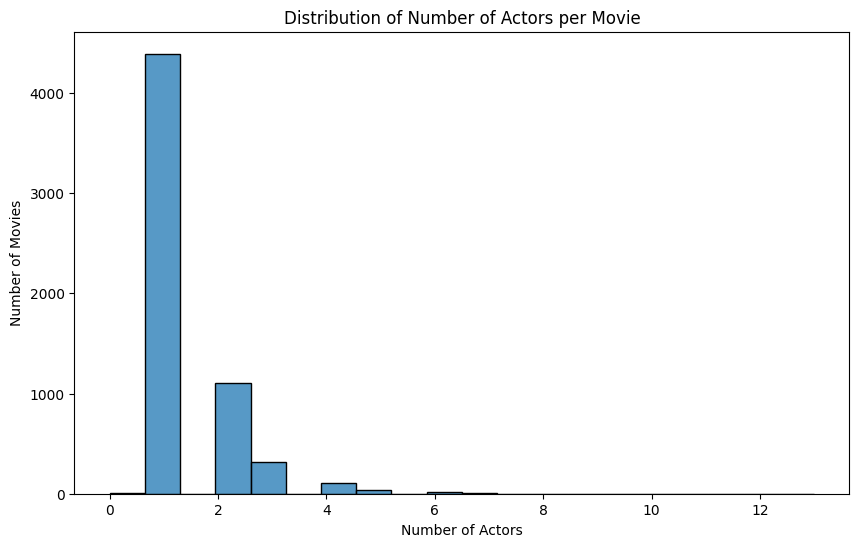

In [ ]:
# Distribution of actors per movie
plt.figure(figsize=(10, 6))
sns.histplot(actors_per_movie, bins=20, kde=False)  # Plot histogram of the number of actors per movie
plt.title('Distribution of Number of Actors per Movie')  # Set the title of the plot
plt.xlabel('Number of Actors')  # Set the x-axis label
plt.ylabel('Number of Movies')  # Set the y-axis label
plt.show()  # Display the plot

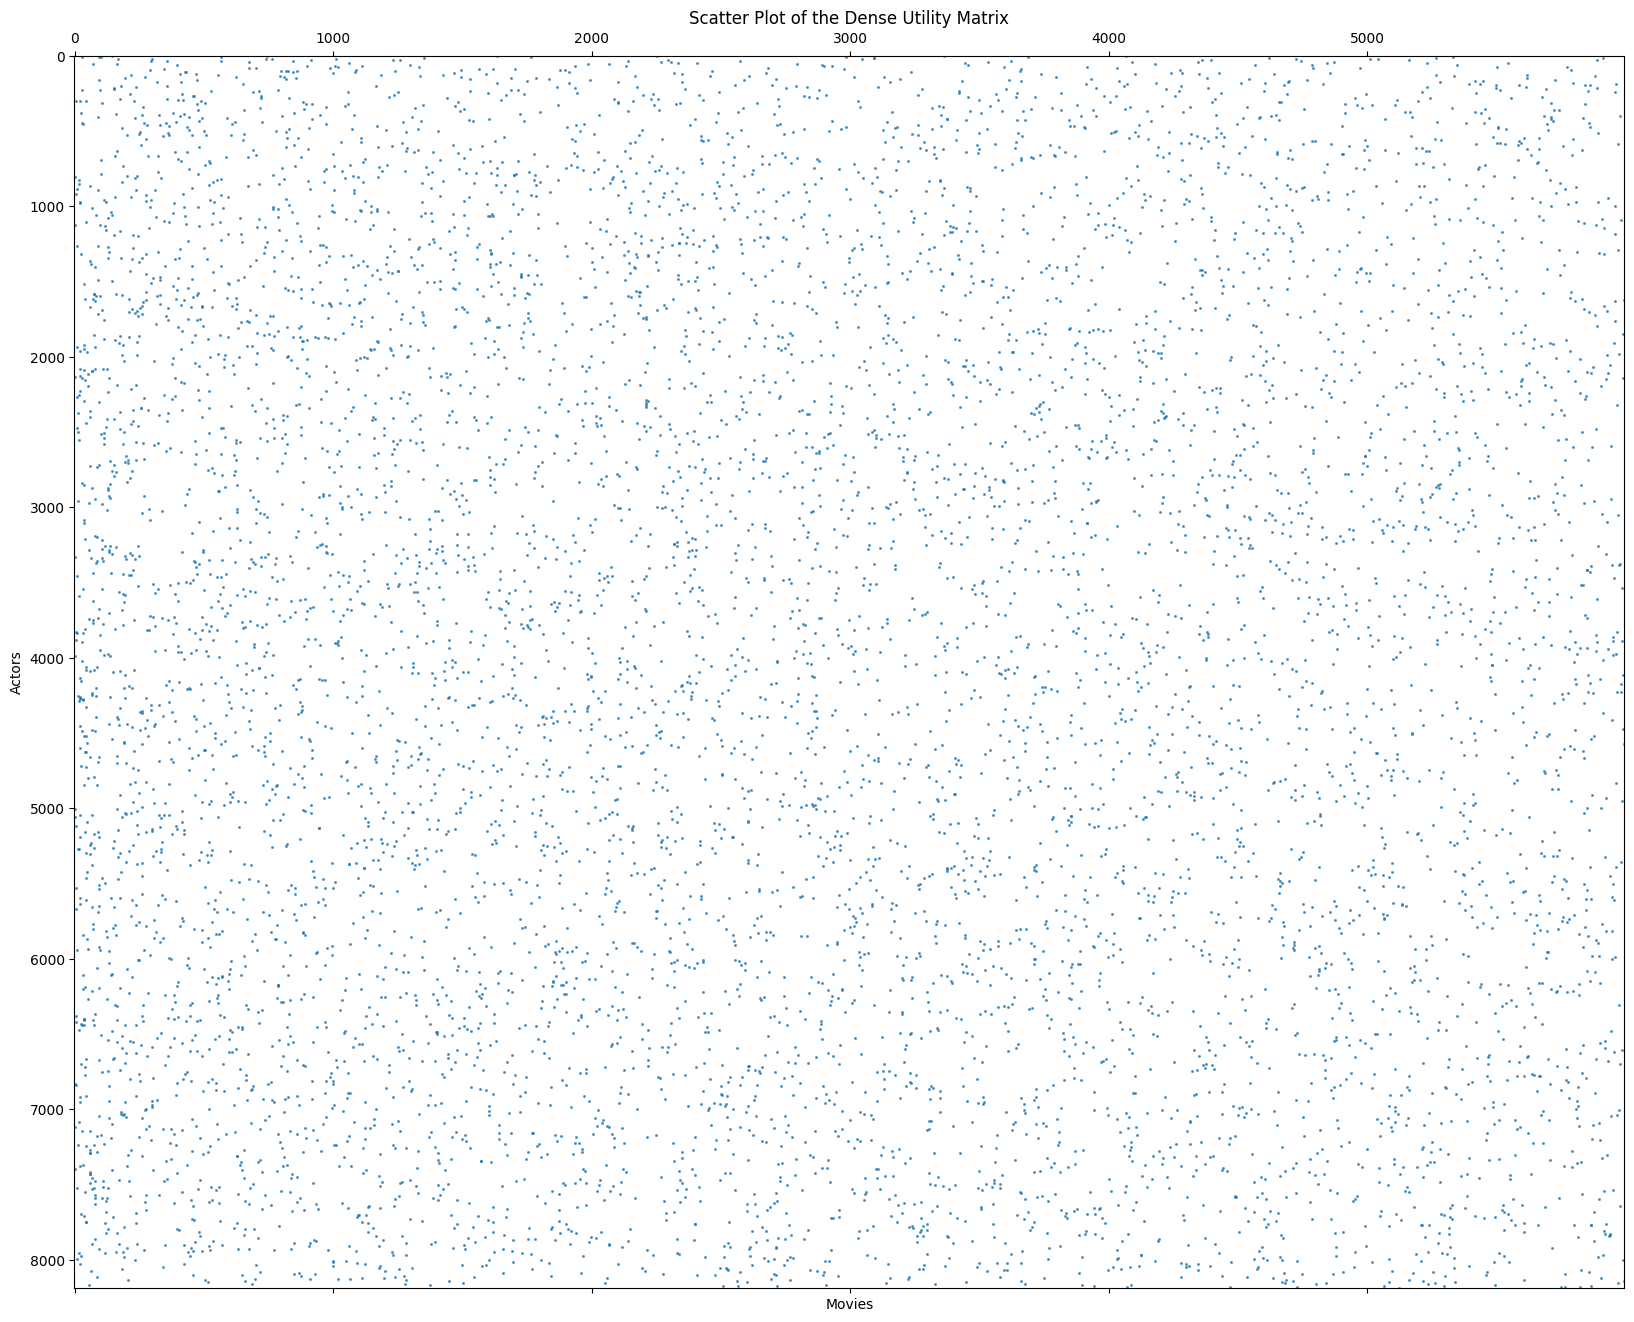

In [ ]:
# Dense matrix scatter plot
plt.figure(figsize=(20,16))
plt.spy(utility_matrix, markersize=1, alpha=0.7, aspect='auto', precision=1e-3, linewidth=0.1)
plt.title("Scatter Plot of the Dense Utility Matrix")
plt.xlabel('Movies')
plt.ylabel('Actors')
plt.grid(False)
plt.show()

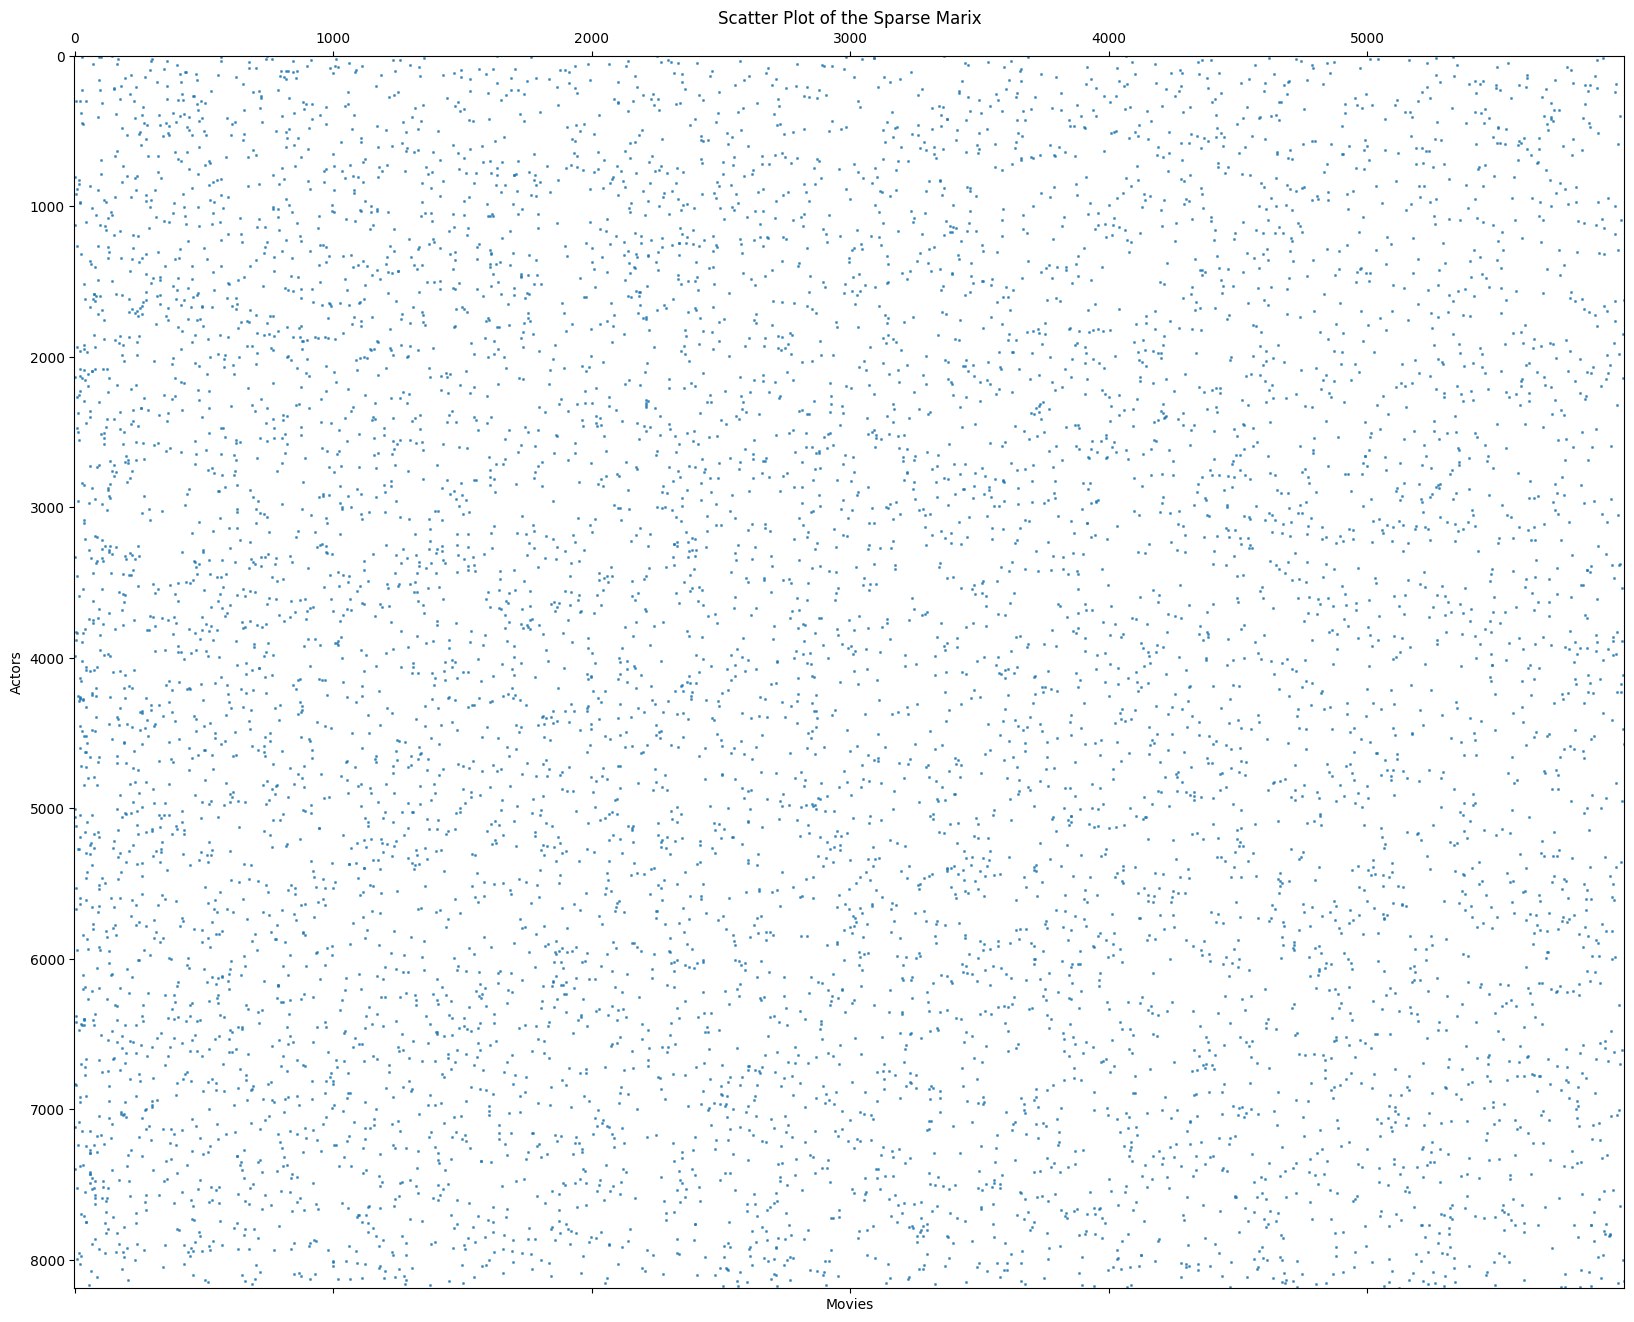

In [ ]:
# Sparse matrix scatter plot
plt.figure(figsize=(20,16))
plt.spy(sparse_matrix, markersize=1, alpha=0.7, aspect='auto', precision=1e-3, linewidth=0.1)
plt.title('Scatter Plot of the Sparse Marix')
plt.xlabel('Movies')
plt.ylabel('Actors')
plt.grid(False)
plt.show()

In [ ]:
# Count the number of unique actors
num_unique_actors = df_actor_movie['actor_name'].nunique()
print(f"Number of unique actors before creating the utility matrix: {num_unique_actors}")

# Number of rows in the utility matrix
num_rows_utility_matrix = len(utility_matrix)
print(f"Number of rows in the utility matrix: {num_rows_utility_matrix}")

# Check if the number of unique actors matches the number of rows in the utility matrix
assert num_unique_actors == num_rows_utility_matrix, "The number of unique actors does not match the number of rows in the utility matrix"


Number of unique actors before creating the utility matrix: 8185
Number of rows in the utility matrix: 8185


# Analysis on the Utility Matrix in case of subsampled data

These results suggest that your utility matrix is extremely sparse, with most actors participating in only a few movies and most movies involving a very limited number of actors. This has implications for choosing between user-based and item-based collaborative filtering:

- **User-based collaborative filtering (similar actors)**: This approach may be less effective if actors have participated in few movies, as there is limited data to compute accurate similarities between them. If most actors have participated in only one movie (as indicated by the data), it will be difficult to find actors with similar tastes.

- **Item-based collaborative filtering (similar movies)**: This approach may have an advantage because it groups movies based on the actors who participated in them. Even if there are few actors per movie, the direct comparison between movies might yield more accurate recommendations, especially if some movies share common actors.

**Conclusion**: Given that the matrix is very sparse and actors have participated in few movies, the item-based collaborative filtering approach may yield better results compared to the user-based method.

## Summary of Differences

- **Similarity Calculation**:
  - **User-Based**: Similarity between users.
  - **Item-Based**: Similarity between items (movies).

- **Recommendation Function**:
  - **User-Based**: Recommendations based on similar users.
  - **Item-Based**: Recommendations based on movies similar to those already liked.

- **Input and Output**:
  - **User-Based**: Input is a user; output is the list of recommended movies based on similar users.
  - **Item-Based**: Input is an actor; output is the list of recommended movies based on movies similar to those the actor has already seen.


# Step 12: Item-based collaborative filtering (similar movies)

In [ ]:
utility_matrix_df = pd.DataFrame(
    utility_matrix,
    index=pivot_table.index,
    columns=pivot_table.columns
)

In [ ]:
utility_matrix_df.head()


id,1000019,1000032,1000044,1000140,1000198,1000277,1000315,1000365,1000392,1000424,...,1935908,1936137,1936902,1940161,1940176,1940262,1940424,1940692,1940729,1940773
actor_name,,,,,,,,,,,,,,,,,,,,,
a. olexa,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
a.c. peterson,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
aahraf khalil,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
aaron domingo,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
aaron eckhart,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# Calculate the similarity matrix between movies
similarity_array = cosine_similarity(utility_matrix_df.T)  # Transpose the matrix to compute similarity between columns (movies)

# Convert the similarity array to a DataFrame
similarity_matrix = pd.DataFrame(
    similarity_array,
    index=utility_matrix_df.columns,
    columns=utility_matrix_df.columns
)


In [ ]:
similarity_matrix.head()

id,1000019,1000032,1000044,1000140,1000198,1000277,1000315,1000365,1000392,1000424,...,1935908,1936137,1936902,1940161,1940176,1940262,1940424,1940692,1940729,1940773
id,,,,,,,,,,,,,,,,,,,,,
1000019,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1000032,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1000044,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1000140,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1000198,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
def recommend_movies(actor_name, num_recommendations=5):
    if actor_name not in utility_matrix_df.index:
        return "Actor not found in the sample."

    watched_movies = utility_matrix_df.loc[actor_name][utility_matrix_df.loc[actor_name] > 0].index

    recommendations = {}
    for movie_id in utility_matrix_df.columns:
        if movie_id not in watched_movies:
            score = sum(
                utility_matrix_df.loc[actor_name].get(watched_movie, 0) * similarity_matrix.loc[movie_id, watched_movie]
                for watched_movie in watched_movies
                if watched_movie in similarity_matrix.index
            )
            if score > 0:
                recommendations[movie_id] = score

    if not recommendations:
        return "No recommendations available based on the scores."

    # Convert movie IDs to titles
    recommendations_with_titles = {}
    for movie_id, score in recommendations.items():
        if movie_id in df_movies['id'].values:
            movie_title = df_movies.loc[df_movies['id'] == movie_id, 'name'].values[0]
            recommendations_with_titles[movie_title] = score
            print(f"Recommended Movie ID: {movie_id}, Movie Title: {movie_title}")
        else:
            print(f"Warning: Movie ID {movie_id} not found in `df_movies`.")

    return dict(sorted(recommendations_with_titles.items(), key=lambda item: item[1], reverse=True)[:num_recommendations])

def recommend_for_random_actor(utility_matrix_df, recommend_movies, num_recommendations=5):
    while True:
        # Select a random actor from the utility matrix DataFrame
        random_actor = random.choice(utility_matrix_df.index.tolist())

        # Get recommendations for the selected actor
        recommendations = recommend_movies(random_actor, num_recommendations)

        # If there are recommendations, return the actor and the recommendations
        if isinstance(recommendations, dict) and recommendations:
            return random_actor, recommendations
        # Otherwise, continue to search for another actor

# Run the function to get recommendations for a random actor
actor_name, recommendations = recommend_for_random_actor(utility_matrix_df, recommend_movies)

# Print the recommendations
print(f"Randomly chosen actor: {actor_name}")
if isinstance(recommendations, dict):
    for movie_title, score in recommendations.items():
        print(f"Recommended movie: {movie_title}\nScore: {score:.7f}\n")
else:
    print(recommendations)  # Show error message if actor is not found


Recommended Movie ID: 1156618, Movie Title: Under-Cover Man
Randomly chosen actor: tom keene
Recommended movie: Under-Cover Man
Score: 0.0111143



In [ ]:
def create_recommendation_df(recommendations, df_movies):
    # Convert movie IDs to a consistent format
    if isinstance(next(iter(recommendations.keys())), str):
        #print("Converting movie titles to IDs.")
        # Assume the keys are movie titles and need to be converted to IDs
        title_to_id = dict(zip(df_movies['name'], df_movies['id']))
        recommendation_ids = [title_to_id.get(movie_id, movie_id) for movie_id in recommendations.keys()]
    else:
        recommendation_ids = [movie_id for movie_id in recommendations.keys()]

    recommendation_scores = [score for score in recommendations.values()]

    # Filter df_movies to get only the recommended movies
    recommended_movies_df = df_movies[df_movies['id'].isin(recommendation_ids)].copy()

    # Identify missing IDs
    missing_ids = set(recommendation_ids) - set(df_movies['id'])
    if missing_ids:
        print(f"Warning: The following recommended movie IDs are missing in df_movies: {missing_ids}")

    # Add scores to the DataFrame
    if not recommended_movies_df.empty:
        recommended_movies_df = recommended_movies_df.set_index('id')
        recommended_movies_df['score'] = recommended_movies_df.index.map(dict(zip(recommendation_ids, recommendation_scores)))
        recommended_movies_df.reset_index(inplace=True)
    else:
        print("No recommended movies are present in df_movies.")

    return recommended_movies_df

# Call the function
recommendation_df = create_recommendation_df(recommendations, df_movies)

# Print the recommendations
if not recommendation_df.empty:
    print(recommendation_df)
else:
    print("No recommendations available to display.")


        id             name  date    minute     score
0  1156618  Under-Cover Man  1932  0.020804  0.011114


In [ ]:
"""def recommend_movies(actor_name, num_recommendations=5):
    # Check if the actor is in the utility matrix
    if actor_name not in utility_matrix.index:
        return "Actor not found in the sample."

    # Get the movies that the actor has watched
    watched_movies = utility_matrix.loc[actor_name][utility_matrix.loc[actor_name] > 0].index

    # Calculate scores for each unwatched movie
    recommendations = {}
    for movie in utility_matrix.columns:
        if movie not in watched_movies:
            # Calculate the movie score based on watched movies
            score = sum(
                utility_matrix.loc[actor_name].get(watched_movie, 0) * similarity_matrix.loc[movie, watched_movie]
                for watched_movie in watched_movies
                if watched_movie in similarity_matrix.index
            )
            if score > 0:
                recommendations[movie] = score

    if not recommendations:
        return "No recommendations available based on the scores."

    # Return the top N recommendations
    return dict(sorted(recommendations.items(), key=lambda item: item[1], reverse=True)[:num_recommendations])"""

'def recommend_movies(actor_name, num_recommendations=5):\n    # Check if the actor is in the utility matrix\n    if actor_name not in utility_matrix.index:\n        return "Actor not found in the sample."\n\n    # Get the movies that the actor has watched\n    watched_movies = utility_matrix.loc[actor_name][utility_matrix.loc[actor_name] > 0].index\n\n    # Calculate scores for each unwatched movie\n    recommendations = {}\n    for movie in utility_matrix.columns:\n        if movie not in watched_movies:\n            # Calculate the movie score based on watched movies\n            score = sum(\n                utility_matrix.loc[actor_name].get(watched_movie, 0) * similarity_matrix.loc[movie, watched_movie]\n                for watched_movie in watched_movies\n                if watched_movie in similarity_matrix.index\n            )\n            if score > 0:\n                recommendations[movie] = score\n\n    if not recommendations:\n        return "No recommendations available 

In [ ]:
"""def recommend_for_random_actor(utility_matrix, recommend_movies, num_recommendations=5):
    while True:
        # Select a random actor from the utility matrix
        random_actor = random.choice(utility_matrix.index.tolist())

        # Get recommendations for the selected actor
        recommendations = recommend_movies(random_actor, num_recommendations)

        # If there are recommendations, return the actor and the recommendations
        if isinstance(recommendations, dict) and recommendations:
            return random_actor, recommendations
        # Otherwise, continue to search for another actor"""


'def recommend_for_random_actor(utility_matrix, recommend_movies, num_recommendations=5):\n    while True:\n        # Select a random actor from the utility matrix\n        random_actor = random.choice(utility_matrix.index.tolist())\n\n        # Get recommendations for the selected actor\n        recommendations = recommend_movies(random_actor, num_recommendations)\n\n        # If there are recommendations, return the actor and the recommendations\n        if isinstance(recommendations, dict) and recommendations:\n            return random_actor, recommendations\n        # Otherwise, continue to search for another actor'

In [ ]:
"""# Run the function to get recommendations for a random actor
actor, recommendations = recommend_for_random_actor(utility_matrix, recommend_movies)

# Print the recommendations
print(f"Randomly chosen actor: {actor}")
if isinstance(recommendations, dict):
    for movie, score in recommendations.items():


        print(f"Recommended movie: {movie}\nScore: {score:.7f}\n")
else:
    print(recommendations)  # Show error message if actor is not found"""

'# Run the function to get recommendations for a random actor\nactor, recommendations = recommend_for_random_actor(utility_matrix, recommend_movies)\n\n# Print the recommendations\nprint(f"Randomly chosen actor: {actor}")\nif isinstance(recommendations, dict):\n    for movie, score in recommendations.items():\n\n\n        print(f"Recommended movie: {movie}\nScore: {score:.7f}\n")\nelse:\n    print(recommendations)  # Show error message if actor is not found'

In [ ]:
"""def recommend_movies(actor_name, num_recommendations=5):
    if actor_name not in utility_matrix.index:
        return "Actor not found in the sample."

    # Ottieni i film che l'attore ha visto
    watched_movies = utility_matrix.loc[actor_name][utility_matrix.loc[actor_name] > 0].index

    # Calcola i punteggi per ogni film non visto
    recommendations = {}
    for movie in utility_matrix.columns:
        if movie not in watched_movies:
            # Calcola il punteggio del film basato sui film visti
            score = sum(
                utility_matrix.loc[actor_name].get(watched_movie, 0) * similarity_matrix.loc[movie, watched_movie]
                for watched_movie in watched_movies
                if watched_movie in similarity_matrix.index
            )
            if score > 0:
                recommendations[movie] = score

    if not recommendations:
        return "No recommendations available based on the scores."

    return dict(sorted(recommendations.items(), key=lambda item: item[1], reverse=True)[:num_recommendations])


def recommend_for_random_actor(utility_matrix, recommend_movies, num_recommendations=5):
    # Seleziona un attore casuale dalla matrice di utilità
    random_actor = random.choice(utility_matrix.index.tolist())

    # Ottieni raccomandazioni per l'attore selezionato
    recommendations = recommend_movies(random_actor, num_recommendations)

    return random_actor, recommendations

# Esegui la funzione per ottenere raccomandazioni per un attore casuale
actor, recommendations = recommend_for_random_actor(utility_matrix, recommend_movies)

# Stampa le raccomandazioni
print(f"Attore scelto casualmente: {actor}")
if isinstance(recommendations, dict):
    for movie, score in recommendations.items():
        print(f"Film raccomandato: {movie}\nPunteggio: {score:.7f}\n")
else:
    print(recommendations)  # Mostra il messaggio di errore se l'attore non è trovato"""

'def recommend_movies(actor_name, num_recommendations=5):\n    if actor_name not in utility_matrix.index:\n        return "Actor not found in the sample."\n\n    # Ottieni i film che l\'attore ha visto\n    watched_movies = utility_matrix.loc[actor_name][utility_matrix.loc[actor_name] > 0].index\n\n    # Calcola i punteggi per ogni film non visto\n    recommendations = {}\n    for movie in utility_matrix.columns:\n        if movie not in watched_movies:\n            # Calcola il punteggio del film basato sui film visti\n            score = sum(\n                utility_matrix.loc[actor_name].get(watched_movie, 0) * similarity_matrix.loc[movie, watched_movie]\n                for watched_movie in watched_movies\n                if watched_movie in similarity_matrix.index\n            )\n            if score > 0:\n                recommendations[movie] = score\n\n    if not recommendations:\n        return "No recommendations available based on the scores."\n\n    return dict(sorted(reco

# Step 13: User-based collaborative filtering (similar actors)

Numero medio di attori per film: 1.98
Deviazione standard del numero di attori per film: 1.58


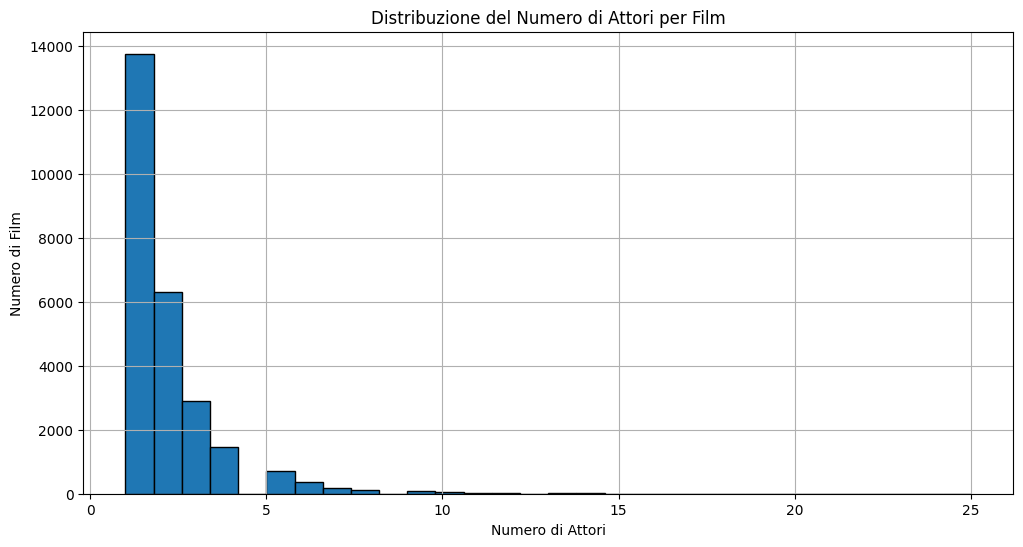

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Supponendo che df_actor_movie sia già caricato e contenga le colonne 'movie_name' e 'actor_name'

# Conta il numero di attori per ciascun film
movie_actor_counts = df_actor_movie.groupby('movie_name')['actor_name'].count()

# Calcola statistiche descrittive
mean_count = movie_actor_counts.mean()
std_count = movie_actor_counts.std()

# Stampa le statistiche
print(f"Numero medio di attori per film: {mean_count:.2f}")
print(f"Deviazione standard del numero di attori per film: {std_count:.2f}")

# Crea un istogramma per visualizzare la distribuzione
plt.figure(figsize=(12, 6))
plt.hist(movie_actor_counts, bins=30, edgecolor='black')
plt.title('Distribuzione del Numero di Attori per Film')
plt.xlabel('Numero di Attori')
plt.ylabel('Numero di Film')
plt.grid(True)
plt.show()


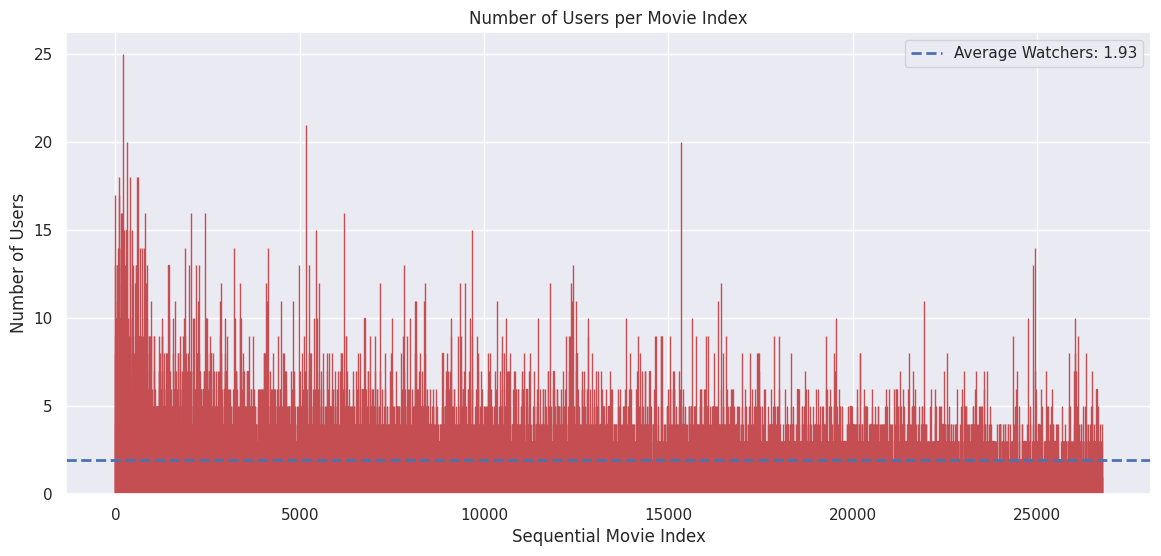

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Supponendo che 'users' sia un DataFrame che contiene informazioni sugli utenti e i film
# Conta il numero di utenti per ciascun film
movie_user_counts = df_actor_movie.groupby('id')['actor_name'].count()

# Calcola la media del numero di utenti per film
average_watchers = movie_user_counts.mean()

# Imposta lo stile del grafico
sns.set(style="darkgrid")

# Crea la figura
plt.figure(figsize=(14, 6))

# Crea un grafico a barre
plt.bar(range(len(movie_user_counts)), movie_user_counts.values, edgecolor='r')

# Aggiunge una linea orizzontale per indicare la media
plt.axhline(average_watchers, color='b', linestyle='--', linewidth=2, label=f'Average Watchers: {average_watchers:.2f}')

# Aggiunge titolo e etichette agli assi
plt.title('Number of Users per Movie Index')
plt.xlabel('Sequential Movie Index')
plt.ylabel('Number of Users')

# Aggiunge una legenda
plt.legend()

# Mostra il grafico
plt.show()


In [ ]:
def recommend_movies(actor_name, num_recommendations=5):
    # Verifica se l'attore è presente nella matrice di similarità
    if actor_name not in similarity_matrix.index:
        return "Attore non trovato nel campione."

    # Calcola la similarità
    similar_actors = similarity_matrix.loc[actor_name]
    print(f"Similar Actors: {similar_actors}")  # Debugging: Mostra gli attori simili

    # Trova gli indici degli attori più simili
    similar_indices = similar_actors.sort_values(ascending=False).index[1:num_recommendations+1]
    print(f"Similar Indices: {similar_indices}")  # Debugging: Mostra gli indici degli attori simili

    # Trova i film raccomandati
    recommendations = {}
    for movie in utility_matrix.columns:
        score = sum(
            utility_matrix.loc[similar_actor].get(movie, 0) * similar_actors[similar_actor]
            for similar_actor in similar_indices
            if similar_actor in utility_matrix.index
        )
        print(f"Movie: {movie}, Score: {score}")  # Debugging: Mostra il punteggio per ogni film
        if score > 0:  # Ignora film con punteggio zero
            recommendations[movie] = f"Totale punteggio basato sui film degli attori simili: {score:.2f}"

    print(f"Recommendations: {recommendations}")  # Debugging: Mostra le raccomandazioni

    if not recommendations:
        return "Nessuna raccomandazione disponibile basata sui punteggi."

    return dict(sorted(recommendations.items(), key=lambda item: item[1], reverse=True)[:num_recommendations])


In [ ]:
import random

def recommend_for_random_actor(df_actors, recommend_movies, max_attempts=100):
    attempts = 0
    while attempts < max_attempts:
        random_actor = random.choice(df_actors['name'].tolist())
        recommendations = recommend_movies(random_actor)

        # Controlla se il risultato è una stringa di errore
        if isinstance(recommendations, str) and recommendations.startswith("Attore"):
            attempts += 1
        else:
            return random_actor, recommendations

    return None, "Nessun attore valido trovato dopo molti tentativi."

# Esegui la funzione per ottenere raccomandazioni
actor, recommendations = recommend_for_random_actor(df_actors, recommend_movies)

# Stampa le raccomandazioni
if actor:
    print(f"Attore scelto casualmente: {actor}")
    if isinstance(recommendations, dict):
        for movie, reason in recommendations.items():
            print(f"Film raccomandato: {movie}\nMotivo: {reason}\n")
    else:
        print(recommendations)  # Mostra il messaggio di errore se l'attore non è trovato
else:
    print(recommendations)  # Mostra il messaggio se non è stato trovato un attore valido


Streaming output truncated to the last 5000 lines.
Movie: The James Brothers of Missouri, Score: 0.0
Movie: The Jazz Detective, Score: 0.0
Movie: The Jekyll and Hyde Portfolio, Score: 0.0
Movie: The Jennie Project, Score: 0.0
Movie: The Jinkx and DeLa Holiday Show 2023, Score: 0.0
Movie: The Joe Spinell Story, Score: 0.0
Movie: The John Sullivan Story, Score: 0.0
Movie: The Joke, Score: 0.0
Movie: The Joker Is Wild, Score: 0.0
Movie: The Journey, Score: 0.0
Movie: The Journey Home, Score: 0.0
Movie: The Journey of Stars Into the Dark Night, Score: 0.0
Movie: The Journey to Kafiristan, Score: 0.0
Movie: The Joy of Life, Score: 0.0
Movie: The Joy of Living, Score: 0.0
Movie: The Joy of Music, Score: 0.0
Movie: The Judge, Score: 0.0
Movie: The Jump, Score: 0.0
Movie: The Junior Squad, Score: 0.0
Movie: The Jupiter Menace, Score: 0.0
Movie: The Jury's Secret, Score: 0.0
Movie: The Jönsson Gang & the Black Diamond, Score: 0.0
Movie: The Jönsson Gang's Greatest Robbery, Score: 0.0
Movie: The

In [ ]:
# Seleziona la riga per l'attore specificato
actor_data = utility_matrix.loc['trevor peacock']

# Filtra i film con valori diversi da zero
non_zero_movies = actor_data[actor_data > 0]

# Stampa i film
print(non_zero_movies)

# Filtra il DataFrame per trovare le righe con il film specificato
actors_in_movie = df_actor_movie[df_actor_movie['movie_name'] == 'Henry VI Part 2']

# Trova gli attori che hanno partecipato a quel film
actors_list = actors_in_movie['actor_name'].tolist()

# Stampa gli attori
print(f"Attori che hanno partecipato al film 'Henry VI Part 2':")
print(actors_list)


movie_name
Henry VI Part 2    1
Name: trevor peacock, dtype: int64
Attori che hanno partecipato al film 'Henry VI Part 2':
['paul chapman', 'trevor peacock', 'peter benson']


# Creating Utility Matrix solo con movies e actors e genres che non funziona ad oggi

In [ ]:
# Example size of df_actor_movie_genre
num_rows = df_actor_movie_genre.shape[0]
num_unique_actors = df_actor_movie_genre['actor_name'].nunique()
num_unique_movies = df_actor_movie_genre['movie_name'].nunique()

print(f"Number of rows in df_actor_movie_genre: {num_rows}")
print(f"Number of unique actors: {num_unique_actors}")
print(f"Number of unique movies: {num_unique_movies}")


Number of rows in df_actor_movie_genre: 8582
Number of unique actors: 8356
Number of unique movies: 4045


In [ ]:
df_actor_movie_genre.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8582 entries, 0 to 8581
Data columns (total 25 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               8582 non-null   int32  
 1   actor_name       8582 non-null   object 
 2   role             8582 non-null   object 
 3   movie_name       8582 non-null   object 
 4   date             8582 non-null   Int64  
 5   minute           8582 non-null   float64
 6   action           8582 non-null   int64  
 7   adventure        8582 non-null   int64  
 8   animation        8582 non-null   int64  
 9   comedy           8582 non-null   int64  
 10  crime            8582 non-null   int64  
 11  documentary      8582 non-null   int64  
 12  drama            8582 non-null   int64  
 13  family           8582 non-null   int64  
 14  fantasy          8582 non-null   int64  
 15  history          8582 non-null   int64  
 16  horror           8582 non-null   int64  
 17  music         

In [ ]:
from scipy.sparse import coo_matrix

# Factorize the 'actor_name' and 'movie_name' columns
actor_indices = pd.factorize(df_actor_movie_genre['actor_name'])[0]
movie_indices = pd.factorize(df_actor_movie_genre['movie_name'])[0]

# Create a sparse matrix using the factorized indices
sparse_matrix = coo_matrix((np.ones(len(df_actor_movie_genre)), (actor_indices, movie_indices)),
                           shape=(len(pd.unique(actor_indices)), len(pd.unique(movie_indices))))

print(f"Sparse matrix shape: {sparse_matrix.shape}")
print(f"Non-zero elements: {sparse_matrix.nnz}")


Sparse matrix shape: (8356, 4045)
Non-zero elements: 8582


##Calculating the cosine distance

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

# Compute cosine similarity between actors
actor_similarity_matrix = cosine_similarity(sparse_matrix)
print(f"Actor similarity matrix shape: {actor_similarity_matrix.shape}")


Actor similarity matrix shape: (8356, 8356)


## Get the raccomandations

In [ ]:
import random
import numpy as np
import pandas as pd

def get_random_recommendations(similarity_matrix, actor_labels, movie_labels, top_n=10):
    # Scegli un attore casuale dal subsample
    random_actor_name = random.choice(actor_labels)
    print(f"Attore selezionato casualmente: {random_actor_name}")

    # Trova l'indice dell'attore scelto
    actor_index = np.where(actor_labels == random_actor_name)[0][0]

    # Ottieni i punteggi di somiglianza per l'attore scelto
    similarity_scores = similarity_matrix[actor_index]

    # Ottieni gli indici degli attori simili
    similar_actors_indices = np.argsort(-similarity_scores)

    # Aggrega i film raccomandati
    recommendations = []
    for similar_actor_index in similar_actors_indices:
        if similar_actor_index == actor_index:
            continue  # Salta l'attore stesso
        similar_actor_name = actor_labels[similar_actor_index]

        # Ottieni i film dell'attore simile
        similar_actor_movies = movie_labels[movie_labels['actor_name'] == similar_actor_name]

        # Aggiungi i film alle raccomandazioni
        recommendations.extend(similar_actor_movies[['movie_name']])

        if len(recommendations) >= top_n:
            break

    # Converti in DataFrame e rimuovi duplicati
    recommendations_df = pd.DataFrame(recommendations).drop_duplicates()
    return recommendations_df.head(top_n)

# Utilizzo della funzione
recommendations = get_random_recommendations(actor_similarity_matrix, pd.unique(actor_indices), df_actor_movie_genre)
print("Top Recommendations:")
print(recommendations)


Attore selezionato casualmente: 7747
Top Recommendations:
            0
0  movie_name


#Final Explanation:
## Collaborative Filtering

- **Core Idea**: Collaborative filtering predicts an actor’s preferences based on the preferences of similar actors.
- **Implementation**:
  - **Similarity Matrix**: We calculated actor similarities based on the movies they've worked in and the genres of those movies.
  - **Recommendations**: We recommended movies to an actor based on what similar actors have done, filtered through genres that the target actor frequently works in.

## Content-Based Filtering

- **Core Idea**: Content-based filtering recommends items based on the features of the items and the preferences of the user.
- **Implementation**:
  - **Genres**: We incorporated movie genres to filter recommendations. This allows us to tailor the recommendations based on the genres that the actor has historically worked in, adding a layer of personalization.

## How Collaborative Filtering is Used

- **Utility Matrix**: Created a utility matrix where rows represent actors and columns represent movie-genre combinations. This matrix helps in calculating how similar actors are to each other.
- **Cosine Similarity**: Used cosine similarity to measure the similarity between actors based on the utility matrix. This step is a fundamental aspect of collaborative filtering.

## How Content-Based Filtering is Used

- **Genre Preference**: The recommendation process considers the genres that an actor has worked in most frequently. This adds a content-based element to the recommendations, as it ensures that the recommended movies align with the actor’s genre preferences.

## Summary

While the primary mechanism is collaborative filtering (using the similarity of actors based on their movie roles), the system also integrates content-based elements by considering movie genres. This hybrid approach enhances the quality of recommendations by combining the strengths of both methods:

- **Collaborative Filtering**: Identifies similarities between actors and suggests movies based on those similarities.
- **Content-Based Filtering**: Refines the recommendations by focusing on genres that match the target actor’s historical preferences.

This hybrid approach is often more effective than using collaborative or content-based filtering alone, as it leverages the benefits of both methodologies.
